In [1]:
# First lets improve libraries that we are going to be used in this lab session
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pickle as pkl
import random
import pdb
random.seed(134)
import pandas as pd
import matplotlib.pyplot as plt

PAD_IDX = 0
UNK_IDX = 1
BATCH_SIZE = 32

In [36]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [2]:
from collections import Counter

# max_vocab_size = 25000
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens):
    token_counter = Counter(all_tokens)
#     print(token_counter)
    vocab = token_counter.keys()
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

def read_data(fine_name):
    df = pd.read_csv(fine_name,sep='\t')
    return df

In [3]:
df_train = read_data("snli_train.tsv")
df_val = read_data("snli_val.tsv")

In [4]:
df_train.head()

,sentence1,sentence2,label
0,A young girl in a pink shirt sitting on a dock...,A young girl watching the sunset over the water .,neutral
1,A woman is smiling while the man next to her i...,Two people are next to each other .,entailment
2,"Across the river , you can see a large building .",The large building is full of apartments and t...,neutral
3,a man in white shorts and a black shirt is par...,A man is riding a jetski on the ocean .,contradiction
4,Four black dogs run together on bright green g...,Four dogs are preparing to be launched into sp...,contradiction


In [5]:
def tokenize(df):
    df['sentence1'] = df['sentence1'].apply(lambda x: [a.lower() for a in x.split(' ')])
    df['sentence2'] = df['sentence2'].apply(lambda x : [a.lower() for a in x.split(' ')])
    
    return df

In [6]:
df_train = tokenize(df_train)
df_val = tokenize(df_val)

In [7]:
df_train.head()

,sentence1,sentence2,label
0,"[a, young, girl, in, a, pink, shirt, sitting, ...","[a, young, girl, watching, the, sunset, over, ...",neutral
1,"[a, woman, is, smiling, while, the, man, next,...","[two, people, are, next, to, each, other, .]",entailment
2,"[across, the, river, ,, you, can, see, a, larg...","[the, large, building, is, full, of, apartment...",neutral
3,"[a, man, in, white, shorts, and, a, black, shi...","[a, man, is, riding, a, jetski, on, the, ocean...",contradiction
4,"[four, black, dogs, run, together, on, bright,...","[four, dogs, are, preparing, to, be, launched,...",contradiction


In [8]:
words_to_load = 100000

import numpy as np

with open('wiki-news-300d-1M.vec') as f:
    loaded_embeddings = np.zeros((words_to_load+2, 300))
    words = {}
    idx2words = {}
    ordered_words = ['<pad>','<unk>']
    i = 2
    for line in f:
        if i-2 >= words_to_load: 
            break
        s = line.split()
        loaded_embeddings[i, :] = np.asarray(s[1:])
        words[s[0]] = i
        idx2words[i] = s[0]
        ordered_words.append(s[0])
        i = i+1

In [9]:
max(words.values())

100001

In [10]:
words['<pad>'] = 0
words['<unk>'] = 1

In [11]:
idx2words[0] = "<pad>"
idx2words[1] = "<unk>"

In [12]:
# ordered_words.append("<pad>")
# ordered_words.append("<unk>")

In [13]:
# words
def apply_idz(x):
    temp = []
    for a in x:
        if a in ordered_words:
            temp.append(words[a])
        else:
            temp.append(1)
    return temp

In [14]:
def idize(df):
    df['sentence1_idz'] = df["sentence1"].apply(apply_idz)
    df['sentence2_idz'] = df["sentence2"].apply(apply_idz)
    return df

In [15]:
train_train = idize(df_train)

In [16]:
val_val = idize(df_val)

In [17]:
unk_vec = np.random.normal(size=300)
pad_vec = np.random.normal(size=300)

In [18]:
loaded_embeddings.shape

(100002, 300)

In [19]:
loaded_embeddings[0,:] = pad_vec
# np.insert(loaded_embeddings,0,pad_vec,axis=0)
loaded_embeddings[1,:] = unk_vec
# np.insert(loaded_embeddings,1,unk_vec,axis=0)

In [20]:
loaded_embeddings.shape

(100002, 300)

In [21]:
train_train.head()

,sentence1,sentence2,label,sentence1_idz,sentence2_idz
0,"[a, young, girl, in, a, pink, shirt, sitting, ...","[a, young, girl, watching, the, sunset, over, ...",neutral,"[10, 803, 1831, 9, 10, 6266, 7168, 4389, 18, 1...","[10, 803, 1831, 2256, 4, 13986, 95, 4, 359, 5]"
1,"[a, woman, is, smiling, while, the, man, next,...","[two, people, are, next, to, each, other, .]",entailment,"[10, 995, 16, 9767, 132, 4, 348, 425, 8, 87, 1...","[108, 68, 35, 425, 8, 205, 72, 5]"
2,"[across, the, river, ,, you, can, see, a, larg...","[the, large, building, is, full, of, apartment...",neutral,"[805, 4, 1939, 3, 33, 85, 139, 10, 543, 403, 5]","[4, 543, 403, 16, 491, 7, 8418, 6, 8810]"
3,"[a, man, in, white, shorts, and, a, black, shi...","[a, man, is, riding, a, jetski, on, the, ocean...",contradiction,"[10, 348, 9, 910, 11908, 6, 10, 885, 7168, 16,...","[10, 348, 16, 5212, 10, 1, 18, 4, 5657, 5]"
4,"[four, black, dogs, run, together, on, bright,...","[four, dogs, are, preparing, to, be, launched,...",contradiction,"[310, 885, 3136, 442, 550, 18, 4809, 1827, 547...","[310, 3136, 35, 4722, 8, 41, 2194, 91, 596, 5]"


In [22]:
def encode_target(train_train):
    train_train['label'][train_train['label']=='neutral']=0
    train_train['label'][train_train['label']=='entailment']=1
    train_train['label'][train_train['label']=='contradiction']=2
    return train_train

In [23]:
train_train = encode_target(train_train)
val_val = encode_target(val_val)

In [24]:
train_train.head()

,sentence1,sentence2,label,sentence1_idz,sentence2_idz
0,"[a, young, girl, in, a, pink, shirt, sitting, ...","[a, young, girl, watching, the, sunset, over, ...",0,"[10, 803, 1831, 9, 10, 6266, 7168, 4389, 18, 1...","[10, 803, 1831, 2256, 4, 13986, 95, 4, 359, 5]"
1,"[a, woman, is, smiling, while, the, man, next,...","[two, people, are, next, to, each, other, .]",1,"[10, 995, 16, 9767, 132, 4, 348, 425, 8, 87, 1...","[108, 68, 35, 425, 8, 205, 72, 5]"
2,"[across, the, river, ,, you, can, see, a, larg...","[the, large, building, is, full, of, apartment...",0,"[805, 4, 1939, 3, 33, 85, 139, 10, 543, 403, 5]","[4, 543, 403, 16, 491, 7, 8418, 6, 8810]"
3,"[a, man, in, white, shorts, and, a, black, shi...","[a, man, is, riding, a, jetski, on, the, ocean...",2,"[10, 348, 9, 910, 11908, 6, 10, 885, 7168, 16,...","[10, 348, 16, 5212, 10, 1, 18, 4, 5657, 5]"
4,"[four, black, dogs, run, together, on, bright,...","[four, dogs, are, preparing, to, be, launched,...",2,"[310, 885, 3136, 442, 550, 18, 4809, 1827, 547...","[310, 3136, 35, 4722, 8, 41, 2194, 91, 596, 5]"


In [25]:
class SnliDataset(Dataset):
    def __init__(self, df):
        self.df = df
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        s1 = self.df.iloc[idx]['sentence1_idz']
        s2 = self.df.iloc[idx]['sentence2_idz']
        tar = self.df.iloc[idx]['label']
        len1 = len(s1)
        len2 = len(s2)
        return [s1,len1,s2,len2,tar]

In [26]:
def max_len(x):
    return len(x)
    

In [27]:
l1 = train_train['sentence1_idz'].apply(max_len)
l2 = train_train['sentence2_idz'].apply(max_len)
# MAX_LEN = max(l1)
MAX_LEN = 25

In [28]:
def vocab_collate_func(batch):
    data_list_s1 = []
    data_list_s2 = []
    label_list = []
    length_list_s1 = []
    length_list_s2 = []

    for datum in batch:
        label_list.append(datum[4])
        length_list_s1.append(datum[1])
        length_list_s2.append(datum[3])
    # padding
    for datum in batch:
        if datum[1]>MAX_LEN:
            padded_vec_s1 = np.array(datum[0])[:MAX_LEN]
        else:
            padded_vec_s1 = np.pad(np.array(datum[0]),
                                pad_width=((0,MAX_LEN - datum[1])),
                                mode="constant", constant_values=0)
        if datum[3]>MAX_LEN:
            padded_vec_s2 = np.array(datum[2])[:MAX_LEN]
        else:
            padded_vec_s2 = np.pad(np.array(datum[2]),
                                pad_width=((0,MAX_LEN - datum[3])),
                                mode="constant", constant_values=0)
        data_list_s1.append(padded_vec_s1)
        data_list_s2.append(padded_vec_s2)
        
    return [torch.from_numpy(np.array(data_list_s1)), torch.LongTensor(length_list_s1), torch.from_numpy(np.array(data_list_s2)), torch.LongTensor(length_list_s2), torch.LongTensor(label_list)]

In [29]:
train_dataset = SnliDataset(train_train)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

val_dataset = SnliDataset(val_val)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)



In [30]:
# a = next(iter(train_loader))

In [31]:
class RNN(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, num_classes, vocab_size):
        super(RNN, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX)
        self.embedding.from_pretrained(torch.from_numpy(loaded_embeddings).cuda(), freeze = True)


        
        self.rnn = nn.GRU(emb_size, hidden_size, num_layers, batch_first = True)
        self.linear1 = nn.Linear(2*hidden_size, 500)
        self.linear2 = nn.Linear(500,num_classes)

    def init_hidden(self, batch_size):
        hidden = torch.randn(self.num_layers, batch_size, self.hidden_size)
        return hidden.cuda()

    def forward(self, data_s1, length1, data_s2, length2):  
        batch_size = data_s1.size(0)
        self.hidden1 = self.init_hidden(batch_size)
        self.hidden2 = self.init_hidden(batch_size)

        embed1 = self.embedding(data_s1)
        embed2 = self.embedding(data_s2)
        
#         print(embed1.size())
        rnn_out1_, hidden1 = self.rnn(embed1, self.hidden1)
        rnn_out2_, hidden2 = self.rnn(embed2, self.hidden2)
#         print(self.hidden1.size())

        rnn_out1 = torch.sum(hidden1, dim=0)
        rnn_out2 = torch.sum(hidden2, dim=0)
#         print(rnn_out1.size())
        combined_out = torch.cat([rnn_out1, rnn_out2], dim=1)
#         print(combined_out.size())
        logits = F.relu(self.linear1(combined_out))
        res = self.linear2(logits)
        
        return res



In [32]:
dataloaders = [train_loader, val_loader]

In [33]:
def training(model,criterion, optimizer, name, num_epochs):
    best_loss = np.inf
    best_acc = 0
    loss_hist = {'train':[],'validate':[]}
    acc_hist = {'train':[],'validate':[]}
    for i in range(num_epochs):
        for enu,phase in enumerate(['train', 'validate']):
            running_loss = 0
            running_total = 0
            correct = 0
            total = 0
            if phase == 'train':
                model.train(True)
            else:
                model.train(False)
            for (data1, length1, data2, length2, labels) in dataloaders[enu]:
#                 data_batch1, length_batch1, data_batch2, len_batch2, label_batch = data1, length1, data2, length2, labels
                data_batch1, len_batch1, data_batch2, len_batch2, label_batch = data1.cuda(), length1.cuda(), data2.cuda(), length2.cuda(), labels.cuda()


                optimizer.zero_grad()
                outputs = model(data_batch1, len_batch1, data_batch2, len_batch2)
                loss = criterion(outputs, label_batch)
                if phase=='train':
                    loss.backward()
                    optimizer.step()
                N = labels.size(0)
                
                outputs = F.softmax(outputs, dim=1)
                predicted = outputs.max(1, keepdim=True)[1]
#                 print(type(predicted))
                total += labels.size(0)
                correct += predicted.eq(label_batch.view_as(predicted)).sum().item()
                running_loss += loss.data[0] * N
                running_total += N
            epoch_loss = running_loss/running_total
            loss_hist[phase].append(epoch_loss.item())
            accuracy = 100 * correct / total
            acc_hist[phase].append(accuracy)
            print('Epoch: {}, Phase: {}, epoch loss: {:.4f}, accuracy: {:.4f}'\
                      .format(i,phase,epoch_loss, accuracy))
        if phase == 'validate' and best_acc < accuracy:
            best_loss = epoch_loss
            best_acc = accuracy
            torch.save(model,name)
    print('Best val dice loss: {:4f}, Best Accuracy: {:4f}'.format(best_loss,best_acc))
    return model, loss_hist, acc_hist

# FeatureMap = 100, Hidden layer = 1

In [38]:
model = RNN(300,100,1,3,words_to_load+2).cuda()
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)

m_save, loss_hists,acc_hist = training(model,criterion,optimizer,"model_rnn16",10)

/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 0, Phase: train, epoch loss: 0.9955, accuracy: 48.7570
Epoch: 0, Phase: validate, epoch loss: 0.8950, accuracy: 58.7000


/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1, Phase: train, epoch loss: 0.8337, accuracy: 62.4160
Epoch: 1, Phase: validate, epoch loss: 0.8604, accuracy: 61.9000
Epoch: 2, Phase: train, epoch loss: 0.7606, accuracy: 66.6530
Epoch: 2, Phase: validate, epoch loss: 0.8581, accuracy: 60.7000
Epoch: 3, Phase: train, epoch loss: 0.7058, accuracy: 69.6550
Epoch: 3, Phase: validate, epoch loss: 0.8716, accuracy: 61.2000
Epoch: 4, Phase: train, epoch loss: 0.6546, accuracy: 72.3270
Epoch: 4, Phase: validate, epoch loss: 0.8688, accuracy: 62.5000
Epoch: 5, Phase: train, epoch loss: 0.6028, accuracy: 74.9290
Epoch: 5, Phase: validate, epoch loss: 0.9325, accuracy: 59.7000
Epoch: 6, Phase: train, epoch loss: 0.5509, accuracy: 77.4990
Epoch: 6, Phase: validate, epoch loss: 1.0005, accuracy: 59.9000
Epoch: 7, Phase: train, epoch loss: 0.5029, accuracy: 79.8420
Epoch: 7, Phase: validate, epoch loss: 1.0014, accuracy: 60.9000
Epoch: 8, Phase: train, epoch loss: 0.4562, accuracy: 81.9200
Epoch: 8, Phase: validate, epoch loss: 1.1384, ac

In [40]:
count_parameters(model)

30223203

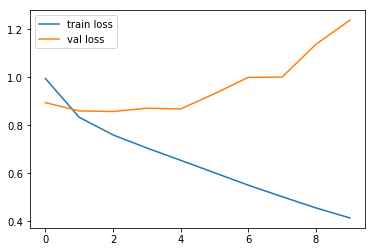

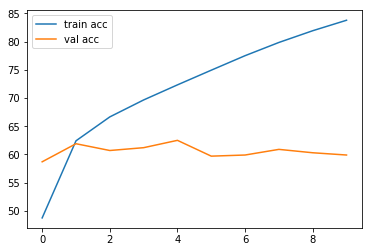

In [39]:
plt.plot(loss_hists['train'],label="train loss")
plt.plot(loss_hists['validate'],label="val loss")
plt.legend()
plt.show()

plt.plot(acc_hist['train'],label="train acc")
plt.plot(acc_hist['validate'],label="val acc")
plt.legend()
plt.show()

# FeatureMap = 700, Hidden layer = 1

In [35]:
model = RNN(300,700,1,3,words_to_load+2).cuda()
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)

m_save, loss_hists,acc_hist = training(model,criterion,optimizer,"model_rnn15",15)

/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 0, Phase: train, epoch loss: 0.9361, accuracy: 54.1190
Epoch: 0, Phase: validate, epoch loss: 0.8473, accuracy: 61.6000


/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1, Phase: train, epoch loss: 0.7840, accuracy: 65.1020
Epoch: 1, Phase: validate, epoch loss: 0.8235, accuracy: 64.0000
Epoch: 2, Phase: train, epoch loss: 0.6905, accuracy: 70.4690
Epoch: 2, Phase: validate, epoch loss: 0.8118, accuracy: 65.1000
Epoch: 3, Phase: train, epoch loss: 0.5929, accuracy: 75.2750
Epoch: 3, Phase: validate, epoch loss: 0.8690, accuracy: 66.5000
Epoch: 4, Phase: train, epoch loss: 0.4845, accuracy: 80.5190
Epoch: 4, Phase: validate, epoch loss: 0.9580, accuracy: 65.9000
Epoch: 5, Phase: train, epoch loss: 0.3776, accuracy: 85.2700
Epoch: 5, Phase: validate, epoch loss: 1.1297, accuracy: 63.8000
Epoch: 6, Phase: train, epoch loss: 0.2942, accuracy: 88.6190
Epoch: 6, Phase: validate, epoch loss: 1.3246, accuracy: 65.3000
Epoch: 7, Phase: train, epoch loss: 0.2381, accuracy: 90.9760
Epoch: 7, Phase: validate, epoch loss: 1.4687, accuracy: 63.7000
Epoch: 8, Phase: train, epoch loss: 0.1963, accuracy: 92.6380
Epoch: 8, Phase: validate, epoch loss: 1.6062, ac

In [46]:
count_parameters(torch.load("model_rnn15"))

32806803

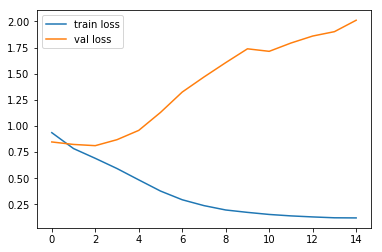

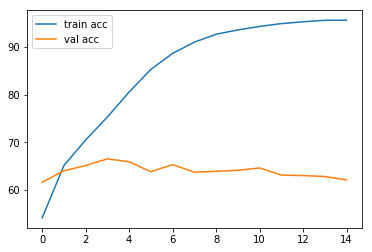

In [37]:
plt.plot(loss_hists['train'],label="train loss")
plt.plot(loss_hists['validate'],label="val loss")
plt.legend()
plt.show()

plt.plot(acc_hist['train'],label="train acc")
plt.plot(acc_hist['validate'],label="val acc")
plt.legend()
plt.show()

# FeatureMap = 500, Hidden layer = 1

In [34]:
model = RNN(300,500,1,3,words_to_load+2).cuda()
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)

m_save, loss_hists,acc_hist = training(model,criterion,optimizer,"model_rnn1",15)

/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 0, Phase: train, epoch loss: 0.9465, accuracy: 53.2870
Epoch: 0, Phase: validate, epoch loss: 0.8525, accuracy: 61.6000


/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1, Phase: train, epoch loss: 0.7934, accuracy: 64.6200
Epoch: 1, Phase: validate, epoch loss: 0.7948, accuracy: 66.5000
Epoch: 2, Phase: train, epoch loss: 0.7011, accuracy: 69.9250
Epoch: 2, Phase: validate, epoch loss: 0.7831, accuracy: 68.2000
Epoch: 3, Phase: train, epoch loss: 0.6069, accuracy: 74.7210
Epoch: 3, Phase: validate, epoch loss: 0.8387, accuracy: 66.0000
Epoch: 4, Phase: train, epoch loss: 0.5042, accuracy: 79.6950
Epoch: 4, Phase: validate, epoch loss: 0.9307, accuracy: 65.6000
Epoch: 5, Phase: train, epoch loss: 0.4041, accuracy: 84.1430
Epoch: 5, Phase: validate, epoch loss: 1.0676, accuracy: 66.4000
Epoch: 6, Phase: train, epoch loss: 0.3193, accuracy: 87.7290
Epoch: 6, Phase: validate, epoch loss: 1.2537, accuracy: 65.1000
Epoch: 7, Phase: train, epoch loss: 0.2527, accuracy: 90.3320
Epoch: 7, Phase: validate, epoch loss: 1.4955, accuracy: 63.1000
Epoch: 8, Phase: train, epoch loss: 0.2110, accuracy: 91.9950
Epoch: 8, Phase: validate, epoch loss: 1.5851, ac

In [47]:
count_parameters(torch.load("model_rnn1"))

31705603

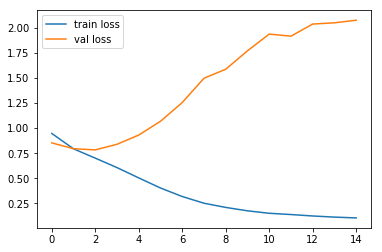

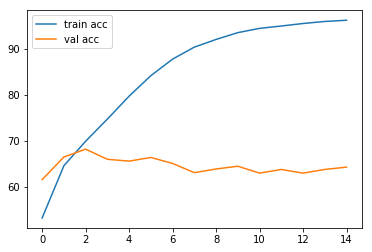

In [35]:
plt.plot(loss_hists['train'],label="train loss")
plt.plot(loss_hists['validate'],label="val loss")
plt.legend()
plt.show()

plt.plot(acc_hist['train'],label="train acc")
plt.plot(acc_hist['validate'],label="val acc")
plt.legend()
plt.show()

# FeatureMap = 200, Hidden layer = 1

In [37]:
model = RNN(300,200,1,3,words_to_load+2).cuda()
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)

m_save, loss_hists,acc_hist = training(model,criterion,optimizer,"model_rnn2",10)

/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 0, Phase: train, epoch loss: 0.9489, accuracy: 53.4740
Epoch: 0, Phase: validate, epoch loss: 0.8738, accuracy: 60.9000


/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 2, Phase: train, epoch loss: 0.7264, accuracy: 68.2950
Epoch: 2, Phase: validate, epoch loss: 0.8314, accuracy: 62.8000
Epoch: 3, Phase: train, epoch loss: 0.6533, accuracy: 72.4710
Epoch: 3, Phase: validate, epoch loss: 0.8757, accuracy: 64.5000
Epoch: 4, Phase: train, epoch loss: 0.5788, accuracy: 76.1880
Epoch: 4, Phase: validate, epoch loss: 0.8698, accuracy: 65.6000
Epoch: 5, Phase: train, epoch loss: 0.5010, accuracy: 79.8920
Epoch: 5, Phase: validate, epoch loss: 0.9600, accuracy: 64.8000
Epoch: 6, Phase: train, epoch loss: 0.4264, accuracy: 83.1120
Epoch: 6, Phase: validate, epoch loss: 1.1090, accuracy: 64.0000
Epoch: 7, Phase: train, epoch loss: 0.3567, accuracy: 86.1960
Epoch: 7, Phase: validate, epoch loss: 1.2335, accuracy: 63.9000
Epoch: 8, Phase: train, epoch loss: 0.3002, accuracy: 88.5450
Epoch: 8, Phase: validate, epoch loss: 1.4393, accuracy: 62.5000
Epoch: 9, Phase: train, epoch loss: 0.2520, accuracy: 90.5050
Epoch: 9, Phase: validate, epoch loss: 1.5555, ac

In [50]:
count_parameters(torch.load("model_rnn2"))

30503803

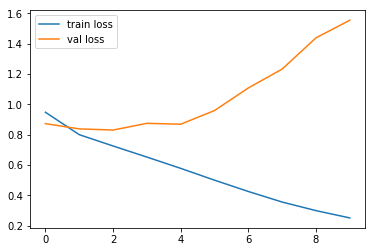

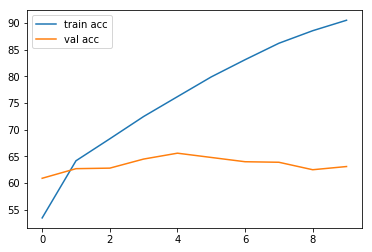

In [38]:
plt.plot(loss_hists['train'],label="train loss")
plt.plot(loss_hists['validate'],label="val loss")
plt.legend()
plt.show()

plt.plot(acc_hist['train'],label="train acc")
plt.plot(acc_hist['validate'],label="val acc")
plt.legend()
plt.show()

# FeatureMap = 500, Hidden layer = 2

In [39]:
model = RNN(300,500,2,3,words_to_load+2).cuda()
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)

m_save, loss_hists,acc_hist = training(model,criterion,optimizer,"model_rnn3",10)

/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 0, Phase: train, epoch loss: 0.9365, accuracy: 53.8670
Epoch: 0, Phase: validate, epoch loss: 0.8707, accuracy: 61.2000


/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1, Phase: train, epoch loss: 0.7829, accuracy: 65.4890
Epoch: 1, Phase: validate, epoch loss: 0.8139, accuracy: 63.6000
Epoch: 2, Phase: train, epoch loss: 0.6929, accuracy: 70.5290
Epoch: 2, Phase: validate, epoch loss: 0.7964, accuracy: 64.7000
Epoch: 3, Phase: train, epoch loss: 0.6009, accuracy: 75.2150
Epoch: 3, Phase: validate, epoch loss: 0.8415, accuracy: 64.7000
Epoch: 4, Phase: train, epoch loss: 0.4995, accuracy: 79.9490
Epoch: 4, Phase: validate, epoch loss: 0.9145, accuracy: 65.6000
Epoch: 5, Phase: train, epoch loss: 0.3995, accuracy: 84.3660
Epoch: 5, Phase: validate, epoch loss: 1.0625, accuracy: 62.8000
Epoch: 6, Phase: train, epoch loss: 0.3172, accuracy: 87.7090
Epoch: 6, Phase: validate, epoch loss: 1.1930, accuracy: 65.0000
Epoch: 7, Phase: train, epoch loss: 0.2519, accuracy: 90.4810
Epoch: 7, Phase: validate, epoch loss: 1.3783, accuracy: 63.8000
Epoch: 9, Phase: train, epoch loss: 0.1783, accuracy: 93.4170
Epoch: 9, Phase: validate, epoch loss: 1.6242, ac

In [51]:
count_parameters(torch.load("model_rnn3"))

33208603

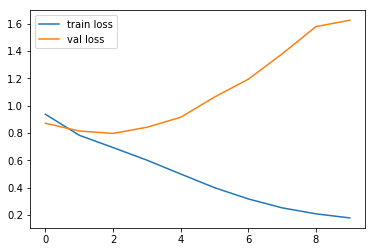

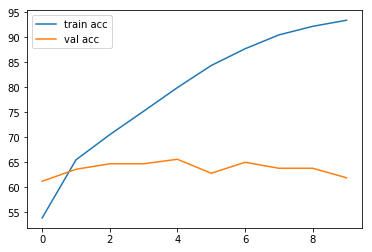

In [40]:
plt.plot(loss_hists['train'],label="train loss")
plt.plot(loss_hists['validate'],label="val loss")
plt.legend()
plt.show()

plt.plot(acc_hist['train'],label="train acc")
plt.plot(acc_hist['validate'],label="val acc")
plt.legend()
plt.show()

# FeatureMap = 500, Hidden layer = 2, weight_decay = 0.00001

In [41]:
model = RNN(300,500,2,3,words_to_load+2).cuda()
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005,weight_decay=0.00001)

m_save, loss_hists,acc_hist = training(model,criterion,optimizer,"model_rnn4",10)

/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 0, Phase: train, epoch loss: 0.9472, accuracy: 53.5510
Epoch: 0, Phase: validate, epoch loss: 0.8425, accuracy: 60.8000


/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1, Phase: train, epoch loss: 0.7899, accuracy: 65.1430
Epoch: 1, Phase: validate, epoch loss: 0.8092, accuracy: 63.0000
Epoch: 2, Phase: train, epoch loss: 0.7157, accuracy: 69.3510
Epoch: 2, Phase: validate, epoch loss: 0.7842, accuracy: 65.8000
Epoch: 3, Phase: train, epoch loss: 0.6498, accuracy: 72.7590
Epoch: 3, Phase: validate, epoch loss: 0.7628, accuracy: 68.3000
Epoch: 4, Phase: train, epoch loss: 0.5815, accuracy: 76.2150
Epoch: 4, Phase: validate, epoch loss: 0.7757, accuracy: 68.1000
Epoch: 5, Phase: train, epoch loss: 0.5113, accuracy: 79.5020
Epoch: 5, Phase: validate, epoch loss: 0.8034, accuracy: 68.2000
Epoch: 6, Phase: train, epoch loss: 0.4384, accuracy: 82.7200
Epoch: 6, Phase: validate, epoch loss: 0.8599, accuracy: 66.6000
Epoch: 7, Phase: train, epoch loss: 0.3686, accuracy: 85.7230
Epoch: 7, Phase: validate, epoch loss: 1.0215, accuracy: 66.0000
Epoch: 8, Phase: train, epoch loss: 0.3029, accuracy: 88.3530
Epoch: 8, Phase: validate, epoch loss: 1.1904, ac

In [52]:
count_parameters(torch.load("model_rnn4"))

33208603

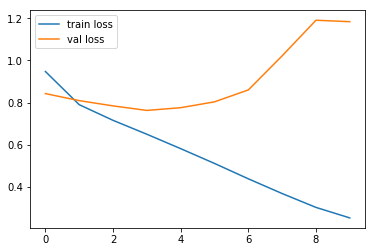

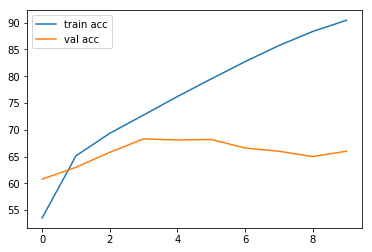

In [42]:
plt.plot(loss_hists['train'],label="train loss")
plt.plot(loss_hists['validate'],label="val loss")
plt.legend()
plt.show()

plt.plot(acc_hist['train'],label="train acc")
plt.plot(acc_hist['validate'],label="val acc")
plt.legend()
plt.show()

# FeatureMap = 500, Hidden layer = 2, weight_decay = 0.0001

In [43]:
model = RNN(300,500,2,3,words_to_load+2).cuda()
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005,weight_decay=0.0001)

m_save, loss_hists,acc_hist = training(model,criterion,optimizer,"model_rnn5",10)

/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 0, Phase: train, epoch loss: 0.9774, accuracy: 51.1160
Epoch: 0, Phase: validate, epoch loss: 0.9002, accuracy: 60.6000


/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1, Phase: train, epoch loss: 0.8394, accuracy: 61.9100
Epoch: 1, Phase: validate, epoch loss: 0.8350, accuracy: 64.4000
Epoch: 2, Phase: train, epoch loss: 0.7977, accuracy: 64.2840
Epoch: 2, Phase: validate, epoch loss: 0.7999, accuracy: 63.8000
Epoch: 3, Phase: train, epoch loss: 0.7688, accuracy: 66.3090
Epoch: 3, Phase: validate, epoch loss: 0.8072, accuracy: 64.6000
Epoch: 5, Phase: train, epoch loss: 0.7207, accuracy: 69.1110
Epoch: 5, Phase: validate, epoch loss: 0.7825, accuracy: 65.6000
Epoch: 6, Phase: train, epoch loss: 0.7043, accuracy: 69.9900
Epoch: 6, Phase: validate, epoch loss: 0.7699, accuracy: 67.8000
Epoch: 7, Phase: train, epoch loss: 0.6879, accuracy: 70.9700
Epoch: 7, Phase: validate, epoch loss: 0.8019, accuracy: 66.8000
Epoch: 8, Phase: train, epoch loss: 0.6746, accuracy: 71.6870
Epoch: 8, Phase: validate, epoch loss: 0.7776, accuracy: 66.5000
Epoch: 9, Phase: train, epoch loss: 0.6585, accuracy: 72.5830
Epoch: 9, Phase: validate, epoch loss: 0.7531, ac

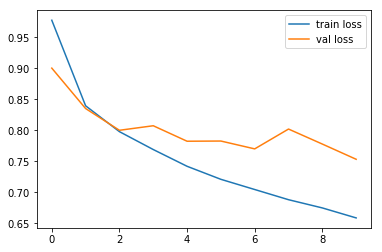

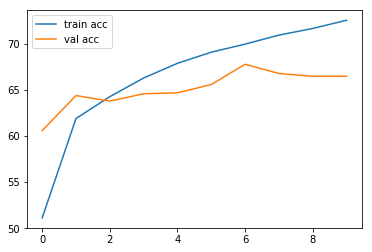

In [44]:
plt.plot(loss_hists['train'],label="train loss")
plt.plot(loss_hists['validate'],label="val loss")
plt.legend()
plt.show()

plt.plot(acc_hist['train'],label="train acc")
plt.plot(acc_hist['validate'],label="val acc")
plt.legend()
plt.show()

# FeatureMap = 500, Hidden layer = 1, weight_decay = 0.00001

In [45]:
model = RNN(300,500,1,3,words_to_load+2).cuda()
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005,weight_decay=0.00001)

m_save, loss_hists,acc_hist = training(model,criterion,optimizer,"model_rnn6",10)

/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 0, Phase: train, epoch loss: 0.9442, accuracy: 53.5030
Epoch: 0, Phase: validate, epoch loss: 0.8623, accuracy: 61.4000


/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1, Phase: train, epoch loss: 0.7914, accuracy: 64.8130
Epoch: 1, Phase: validate, epoch loss: 0.8124, accuracy: 64.2000
Epoch: 2, Phase: train, epoch loss: 0.7196, accuracy: 68.8450
Epoch: 2, Phase: validate, epoch loss: 0.7810, accuracy: 64.7000
Epoch: 3, Phase: train, epoch loss: 0.6594, accuracy: 72.2450
Epoch: 3, Phase: validate, epoch loss: 0.7810, accuracy: 66.9000
Epoch: 4, Phase: train, epoch loss: 0.5931, accuracy: 75.5970
Epoch: 4, Phase: validate, epoch loss: 0.8030, accuracy: 67.4000
Epoch: 5, Phase: train, epoch loss: 0.5223, accuracy: 79.0640
Epoch: 5, Phase: validate, epoch loss: 0.8646, accuracy: 67.4000
Epoch: 6, Phase: train, epoch loss: 0.4424, accuracy: 82.4850
Epoch: 6, Phase: validate, epoch loss: 0.9371, accuracy: 66.0000
Epoch: 7, Phase: train, epoch loss: 0.3643, accuracy: 85.9670
Epoch: 7, Phase: validate, epoch loss: 1.0820, accuracy: 66.5000
Epoch: 8, Phase: train, epoch loss: 0.2974, accuracy: 88.7290
Epoch: 8, Phase: validate, epoch loss: 1.2021, ac

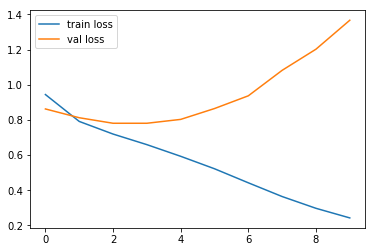

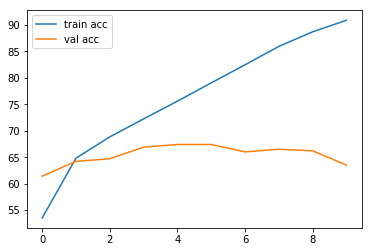

In [46]:
plt.plot(loss_hists['train'],label="train loss")
plt.plot(loss_hists['validate'],label="val loss")
plt.legend()
plt.show()

plt.plot(acc_hist['train'],label="train acc")
plt.plot(acc_hist['validate'],label="val acc")
plt.legend()
plt.show()

In [42]:
class RNN_dp(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, num_classes, vocab_size,p_p):
        super(RNN_dp, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX)
#         self.embedding.weight.data.copy_(torch.from_numpy(loaded_embeddings))
#         self.embedding.weight.requires_grad = False
        self.embedding.from_pretrained(torch.from_numpy(loaded_embeddings).cuda(), freeze = True)
        self.drop = nn.Dropout(p=p_p)


        
        self.rnn = nn.GRU(emb_size, hidden_size, num_layers, batch_first = True)
        self.linear1 = nn.Linear(2*hidden_size, 500)
        self.linear2 = nn.Linear(500,num_classes)

    def init_hidden(self, batch_size):
        hidden = torch.randn(self.num_layers, batch_size, self.hidden_size)
        return hidden.cuda()

    def forward(self, data_s1, length1, data_s2, length2):  
        batch_size = data_s1.size(0)
        self.hidden1 = self.init_hidden(batch_size)
        self.hidden2 = self.init_hidden(batch_size)

        embed1 = self.embedding(data_s1)
        embed2 = self.embedding(data_s2)
        
#         print(embed1.size())
        rnn_out1_, hidden1 = self.rnn(embed1, self.hidden1)
        rnn_out2_, hidden2 = self.rnn(embed2, self.hidden2)
#         print(self.hidden1.size())

        rnn_out1 = torch.sum(hidden1, dim=0)
        rnn_out2 = torch.sum(hidden2, dim=0)
#         print(rnn_out1.size())
        combined_out = torch.cat([rnn_out1, rnn_out2], dim=1)
#         print(combined_out.size())
        logits = F.relu(self.linear1(combined_out))
        res = self.linear2(self.drop(logits))
        
        return res




# FeatureMap = 500, Hidden layer = 2, drop_out = 0.5

In [99]:
model = RNN_dp(300,500,2,3,words_to_load+2,0.5).cuda()
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)

m_save, loss_hists,acc_hist = training(model,criterion,optimizer,"model_rnn7",10)

/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 0, Phase: train, epoch loss: 0.9452, accuracy: 54.0530
Epoch: 0, Phase: validate, epoch loss: 0.8438, accuracy: 60.7000


/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type RNN_dp. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1, Phase: train, epoch loss: 0.8003, accuracy: 64.6870
Epoch: 1, Phase: validate, epoch loss: 0.8051, accuracy: 63.6000
Epoch: 2, Phase: train, epoch loss: 0.7189, accuracy: 69.1830
Epoch: 2, Phase: validate, epoch loss: 0.7801, accuracy: 65.4000
Epoch: 3, Phase: train, epoch loss: 0.6375, accuracy: 73.3940
Epoch: 3, Phase: validate, epoch loss: 0.8118, accuracy: 66.0000
Epoch: 4, Phase: train, epoch loss: 0.5480, accuracy: 77.8100
Epoch: 4, Phase: validate, epoch loss: 0.8602, accuracy: 65.8000
Epoch: 5, Phase: train, epoch loss: 0.4607, accuracy: 81.7090
Epoch: 5, Phase: validate, epoch loss: 0.9747, accuracy: 65.9000
Epoch: 6, Phase: train, epoch loss: 0.3810, accuracy: 85.0530
Epoch: 6, Phase: validate, epoch loss: 1.1774, accuracy: 64.2000
Epoch: 7, Phase: train, epoch loss: 0.3211, accuracy: 87.5490
Epoch: 7, Phase: validate, epoch loss: 1.3271, accuracy: 65.2000
Epoch: 8, Phase: train, epoch loss: 0.2775, accuracy: 89.2930
Epoch: 8, Phase: validate, epoch loss: 1.3867, ac

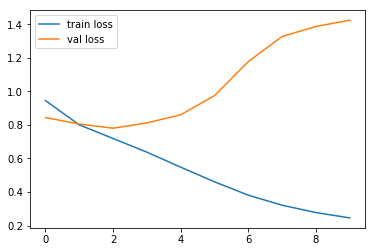

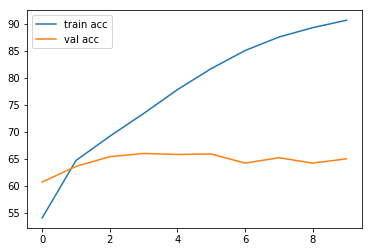

In [100]:
plt.plot(loss_hists['train'],label="train loss")
plt.plot(loss_hists['validate'],label="val loss")
plt.legend()
plt.show()

plt.plot(acc_hist['train'],label="train acc")
plt.plot(acc_hist['validate'],label="val acc")
plt.legend()
plt.show()

# FeatureMap = 500, Hidden layer = 2, drop_out = 0.8

In [54]:
model = RNN_dp(300,500,2,3,words_to_load+2,0.8).cuda()
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)

m_save, loss_hists,acc_hist = training(model,criterion,optimizer,"model_rnn8",10)

/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 0, Phase: train, epoch loss: 0.9671, accuracy: 52.3970
Epoch: 0, Phase: validate, epoch loss: 0.8757, accuracy: 58.8000


/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type RNN_dp. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1, Phase: train, epoch loss: 0.8264, accuracy: 63.2370
Epoch: 1, Phase: validate, epoch loss: 0.8177, accuracy: 62.4000
Epoch: 2, Phase: train, epoch loss: 0.7571, accuracy: 67.2610
Epoch: 2, Phase: validate, epoch loss: 0.8126, accuracy: 63.2000
Epoch: 3, Phase: train, epoch loss: 0.6866, accuracy: 70.8300
Epoch: 3, Phase: validate, epoch loss: 0.8383, accuracy: 64.7000
Epoch: 4, Phase: train, epoch loss: 0.6101, accuracy: 74.6100
Epoch: 4, Phase: validate, epoch loss: 0.8607, accuracy: 66.4000
Epoch: 5, Phase: train, epoch loss: 0.5332, accuracy: 78.2650
Epoch: 5, Phase: validate, epoch loss: 0.9267, accuracy: 64.4000
Epoch: 6, Phase: train, epoch loss: 0.4640, accuracy: 81.3180
Epoch: 6, Phase: validate, epoch loss: 1.0835, accuracy: 65.2000
Epoch: 7, Phase: train, epoch loss: 0.4010, accuracy: 83.9630
Epoch: 7, Phase: validate, epoch loss: 1.1813, accuracy: 64.0000
Epoch: 8, Phase: train, epoch loss: 0.3558, accuracy: 86.0240
Epoch: 8, Phase: validate, epoch loss: 1.2989, ac

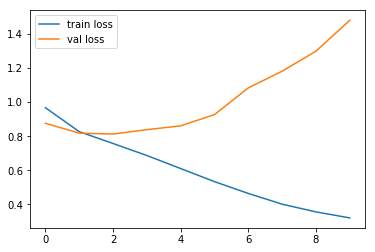

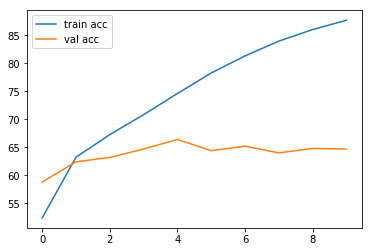

In [55]:
plt.plot(loss_hists['train'],label="train loss")
plt.plot(loss_hists['validate'],label="val loss")
plt.legend()
plt.show()

plt.plot(acc_hist['train'],label="train acc")
plt.plot(acc_hist['validate'],label="val acc")
plt.legend()
plt.show()

# FeatureMap = 500, Hidden layer = 2, drop_out = 0.3

In [56]:
model = RNN_dp(300,500,2,3,words_to_load+2,0.3).cuda()
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)

m_save, loss_hists,acc_hist = training(model,criterion,optimizer,"model_rnn9",10)

/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 0, Phase: train, epoch loss: 0.9413, accuracy: 54.4540
Epoch: 0, Phase: validate, epoch loss: 0.8723, accuracy: 59.8000


/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type RNN_dp. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1, Phase: train, epoch loss: 0.7960, accuracy: 64.8640
Epoch: 1, Phase: validate, epoch loss: 0.8110, accuracy: 64.5000
Epoch: 2, Phase: train, epoch loss: 0.7127, accuracy: 69.4300
Epoch: 2, Phase: validate, epoch loss: 0.7941, accuracy: 66.1000
Epoch: 3, Phase: train, epoch loss: 0.6286, accuracy: 73.7120
Epoch: 3, Phase: validate, epoch loss: 0.8707, accuracy: 66.1000
Epoch: 4, Phase: train, epoch loss: 0.5351, accuracy: 78.0890
Epoch: 4, Phase: validate, epoch loss: 0.9461, accuracy: 65.8000
Epoch: 5, Phase: train, epoch loss: 0.4447, accuracy: 82.1790
Epoch: 5, Phase: validate, epoch loss: 1.0580, accuracy: 67.3000
Epoch: 6, Phase: train, epoch loss: 0.3649, accuracy: 85.6010
Epoch: 6, Phase: validate, epoch loss: 1.2317, accuracy: 66.5000
Epoch: 7, Phase: train, epoch loss: 0.3042, accuracy: 88.0850
Epoch: 7, Phase: validate, epoch loss: 1.4554, accuracy: 62.6000
Epoch: 8, Phase: train, epoch loss: 0.2587, accuracy: 89.9330
Epoch: 8, Phase: validate, epoch loss: 1.4327, ac

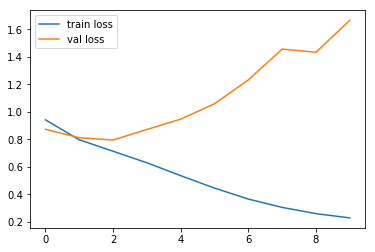

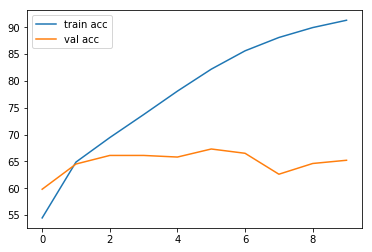

In [57]:
plt.plot(loss_hists['train'],label="train loss")
plt.plot(loss_hists['validate'],label="val loss")
plt.legend()
plt.show()

plt.plot(acc_hist['train'],label="train acc")
plt.plot(acc_hist['validate'],label="val acc")
plt.legend()
plt.show()

# FeatureMap = 500, Hidden layer = 2, drop_out = 0.2, weight_decay = 0.000001

In [44]:
model = RNN_dp(300,500,2,3,words_to_load+2,0.2).cuda()
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005,weight_decay=0.000001)

m_save, loss_hists,acc_hist = training(model,criterion,optimizer,"model_rnn17",10)

/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 0, Phase: train, epoch loss: 0.9418, accuracy: 53.7700
Epoch: 0, Phase: validate, epoch loss: 0.8505, accuracy: 61.2000


/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type RNN_dp. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1, Phase: train, epoch loss: 0.7883, accuracy: 65.3570
Epoch: 1, Phase: validate, epoch loss: 0.8103, accuracy: 64.5000
Epoch: 2, Phase: train, epoch loss: 0.7046, accuracy: 69.9830
Epoch: 2, Phase: validate, epoch loss: 0.7918, accuracy: 65.9000
Epoch: 3, Phase: train, epoch loss: 0.6230, accuracy: 74.0960
Epoch: 3, Phase: validate, epoch loss: 0.8149, accuracy: 66.5000
Epoch: 4, Phase: train, epoch loss: 0.5363, accuracy: 78.2180
Epoch: 4, Phase: validate, epoch loss: 0.9345, accuracy: 65.3000
Epoch: 5, Phase: train, epoch loss: 0.4449, accuracy: 82.4760
Epoch: 5, Phase: validate, epoch loss: 0.9950, accuracy: 65.6000
Epoch: 6, Phase: train, epoch loss: 0.3628, accuracy: 85.8550
Epoch: 6, Phase: validate, epoch loss: 1.1698, accuracy: 65.3000
Epoch: 7, Phase: train, epoch loss: 0.3023, accuracy: 88.2760
Epoch: 7, Phase: validate, epoch loss: 1.3651, accuracy: 64.4000
Epoch: 8, Phase: train, epoch loss: 0.2529, accuracy: 90.2080
Epoch: 8, Phase: validate, epoch loss: 1.4581, ac

33208603


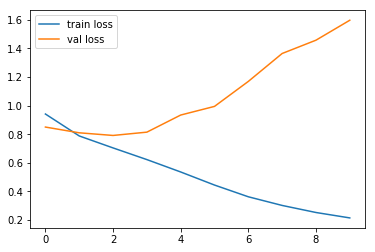

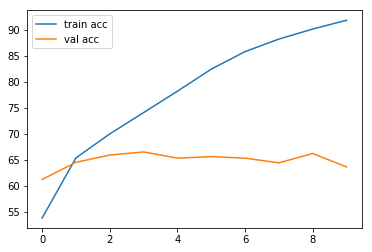

In [45]:
print(count_parameters(model))
plt.plot(loss_hists['train'],label="train loss")
plt.plot(loss_hists['validate'],label="val loss")
plt.legend()
plt.show()

plt.plot(acc_hist['train'],label="train acc")
plt.plot(acc_hist['validate'],label="val acc")
plt.legend()
plt.show()

In [66]:
class RNN_learn(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, num_classes, vocab_size,p_p):
        super(RNN_learn, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX)
#         self.embedding.weight.data.copy_(torch.from_numpy(loaded_embeddings))
#         self.embedding.weight.requires_grad = False
        self.embedding.from_pretrained(torch.from_numpy(loaded_embeddings).cuda(), freeze = True)
    
        
#         self.drop = nn.Dropout(p=p_p)


        
        self.rnn = nn.GRU(emb_size, hidden_size, num_layers, batch_first = True)
        self.linear1 = nn.Linear(2*hidden_size, 500)
        self.linear2 = nn.Linear(500,num_classes)

    def init_hidden(self, batch_size):
        hidden = torch.randn(self.num_layers, batch_size, self.hidden_size)
        return hidden.cuda()

    def forward(self, data_s1, length1, data_s2, length2):  
        batch_size = data_s1.size(0)
        self.hidden1 = self.init_hidden(batch_size)
        self.hidden2 = self.init_hidden(batch_size)

        embed1 = self.embedding(data_s1)
        m1 = (data_s1 == 1).type(torch.cuda.FloatTensor)
        m1 = m1.unsqueeze(2).repeat(1, 1, 300)
        embed1 = m1 * embed1 + (1-m1) * embed1.clone().detach()

        embed2 = self.embedding(data_s2)
        m2 = (data_s2 == 1).type(torch.cuda.FloatTensor)
        m2 = m2.unsqueeze(2).repeat(1, 1, 300)
        embed2 = m2 * embed2 + (1-m2) * embed2.clone().detach()

        
#         print(embed1.size())
        rnn_out1_, hidden1 = self.rnn(embed1, self.hidden1)
        rnn_out2_, hidden2 = self.rnn(embed2, self.hidden2)
#         print(self.hidden1.size())

        rnn_out1 = torch.sum(hidden1, dim=0)
        rnn_out2 = torch.sum(hidden2, dim=0)
#         print(rnn_out1.size())
        combined_out = torch.cat([rnn_out1, rnn_out2], dim=1)
#         print(combined_out.size())
        logits = F.relu(self.linear1(combined_out))
        res = self.linear2(logits)
        
        return res





# Learning 'unk' unknown parameter

In [68]:
model = RNN_learn(300,500,2,3,words_to_load+2,0).cuda()
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)

m_save, loss_hists,acc_hist = training(model,criterion,optimizer,"model_rnn10",10)

/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 0, Phase: train, epoch loss: 0.9570, accuracy: 53.1220
Epoch: 0, Phase: validate, epoch loss: 0.8942, accuracy: 58.1000


/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type RNN_learn. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1, Phase: train, epoch loss: 0.8188, accuracy: 63.0680
Epoch: 1, Phase: validate, epoch loss: 0.8145, accuracy: 61.6000
Epoch: 2, Phase: train, epoch loss: 0.7341, accuracy: 68.0780
Epoch: 2, Phase: validate, epoch loss: 0.8081, accuracy: 64.2000
Epoch: 3, Phase: train, epoch loss: 0.6478, accuracy: 72.6080
Epoch: 3, Phase: validate, epoch loss: 0.8407, accuracy: 63.8000
Epoch: 4, Phase: train, epoch loss: 0.5478, accuracy: 77.5940
Epoch: 4, Phase: validate, epoch loss: 0.9363, accuracy: 62.3000
Epoch: 5, Phase: train, epoch loss: 0.4511, accuracy: 81.9370
Epoch: 5, Phase: validate, epoch loss: 0.9907, accuracy: 65.8000
Epoch: 6, Phase: train, epoch loss: 0.3632, accuracy: 85.7970
Epoch: 6, Phase: validate, epoch loss: 1.1494, accuracy: 62.5000
Epoch: 7, Phase: train, epoch loss: 0.2972, accuracy: 88.5230
Epoch: 7, Phase: validate, epoch loss: 1.2494, accuracy: 63.3000
Epoch: 8, Phase: train, epoch loss: 0.2518, accuracy: 90.3980
Epoch: 8, Phase: validate, epoch loss: 1.3323, ac

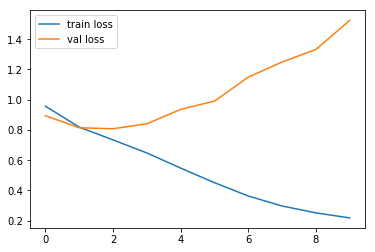

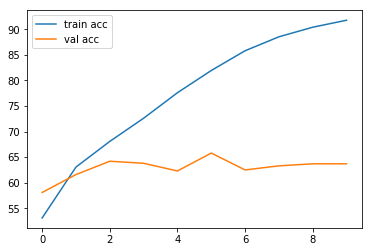

In [69]:
plt.plot(loss_hists['train'],label="train loss")
plt.plot(loss_hists['validate'],label="val loss")
plt.legend()
plt.show()

plt.plot(acc_hist['train'],label="train acc")
plt.plot(acc_hist['validate'],label="val acc")
plt.legend()
plt.show()